In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3})
tab20_colors = plt.cm.get_cmap('tab20').colors

import os, pickle, torch
import numpy as np

# Load trained model from similarity regularization

In [2]:
benchmarks_dir = 'benchmarks'
cache_dir = 'cache'
models_dir = 'cnn_models'

with open(os.path.join(models_dir, 'model.ids.pickle'), 'rb') as f:
    catalog = pickle.load(f)

In [3]:
print('accuracy on clean dataset')
clean_accs = {}
for key, model_ids in catalog.items():
    clean_accs[key] = []
    for model_id in model_ids:
        saved = torch.load(os.path.join(models_dir, 'exported', f'{model_id}.pt'))
        clean_accs[key].append(saved['accs']['test'][saved['best_epoch']])
    if clean_accs[key]:
        print('{:10} {:.2%} ({:.2%})'.format('\'{}\':'.format(key), np.mean(clean_accs[key]), np.std(clean_accs[key])/len(clean_accs[key])**0.5))

accuracy on clean dataset
'none':    92.36% (0.16%)
'neural':  88.63% (0.26%)
'shuffle': 88.78% (0.70%)


# Test model robustness against random distortions

In [4]:
from roarena.tester import test_random_distortions

distortions = [
    ('Gaussian', 0.05),
    ('Gaussian', 0.15),
    ('Uniform', 0.1),
    ('Uniform', 0.3),
    ('SaltPepper', 0.04),
    ('SaltPepper', 0.12),
    ('LowPass', 1.2),
    ('HighPass', 0.4),
]

# test models with random distortions
noisy_accs = {}
for key, model_ids in catalog.items():
    print('testing {} \'{}\' models...'.format(len(model_ids), key))
    noisy_accs[key] = {}
    for d_type, d_val in distortions:
        noisy_accs[key][(d_type, d_val)] = []
    for model_id in model_ids:
        print(model_id)
        saved = torch.load(os.path.join(models_dir, 'exported', f'{model_id}.pt'))
        model = saved['model']
        for d_type, d_val in distortions:
            _, acc = test_random_distortions(
                model, saved['config']['model_config']['task'], d_type, d_val,
                benchmarks_dir, cache_dir
            )
            noisy_accs[key][(d_type, d_val)].append(acc)

# gather results
accs_mean = np.full((len(catalog), len(distortions)+1), np.nan)
accs_sem = np.full((len(catalog), len(distortions)+1), np.nan)
catalog_keys = list(catalog.keys())
d_labels = [f'{d_type}-{d_val}' for d_type, d_val in distortions]
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        accs_mean[k_idx, 0] = np.mean(clean_accs[key])
        accs_sem[k_idx, 0] = np.std(clean_accs[key])/len(clean_accs[key])**0.5

        for d_idx, (d_type, d_val) in enumerate(distortions, 1):
            accs_mean[k_idx, d_idx] = np.mean(noisy_accs[key][(d_type, d_val)])
            accs_sem[k_idx, d_idx] = np.std(noisy_accs[key][(d_type, d_val)])/len(noisy_accs[key][(d_type, d_val)])**0.5

/foolbox/foolbox/attacks/brendel_bethge.py:624: UserWarning: At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.
  warnings.warn(


testing 5 'none' models...
EAE1625A
E0D869C0
A8E8F7CD
8956FAC3
4EB279F4
testing 8 'neural' models...
2D7FCE36
95DEAC78
7CAE337D
B82555E8
37CB4C0A
4B006298
23298786
C4325663
testing 4 'shuffle' models...
80FC96B9
14F71010
8B29B9CA
C47540F7


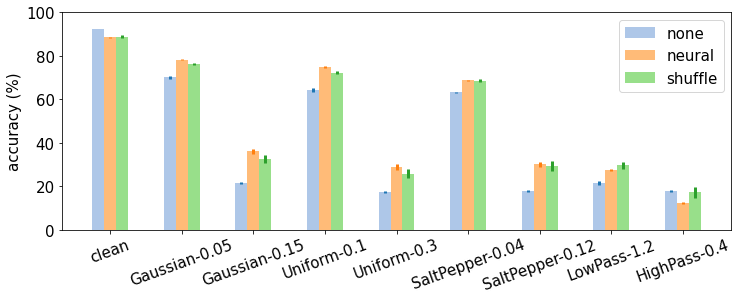

In [5]:
_, ax = plt.subplots(figsize=(12, 4))

width = 0.5/len(catalog)
h_bars = []
for k_idx, key in enumerate(catalog_keys):
    if catalog[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        x = np.arange(len(distortions)+1)+(k_idx-(len(catalog)-1)/2)*width
        h_bars.append(ax.bar(x, accs_mean[k_idx]*100, width, facecolor=fcolor))
        ax.errorbar(x, accs_mean[k_idx]*100, accs_sem[k_idx]*100, linestyle='none', ecolor=ecolor)
ax.set_xticks(np.arange(len(distortions)+1))
ax.set_xticklabels(['clean']+d_labels, rotation=20)
ax.set_ylabel('accuracy (%)')
ax.set_ylim([0, 100])
ax.legend(h_bars, catalog_keys)
plt.show()

# Test model robustness against adversarial attacks

In [6]:
from roarena.tester import AttackJob

attack_job = AttackJob('adv_attacks', benchmarks_dir)

# attack models using foolbox
advs, dists = {}, {}
for key, model_ids in catalog.items():
    print('attacking {} \'{}\' models...'.format(len(model_ids), key))
    advs[key], dists[key] = [], []
    for model_id in model_ids:
        print(model_id)
        attack_config = attack_job.get_work_config('--model_pth {}/exported/{}.pt --norm Linf'.format(models_dir, model_id).split())
        w_id = attack_job.process(attack_config, policy='preserve', silent_mode=True)
        output = attack_job.outputs.fetch_record(w_id)

        advs[key].append(output['advs'])
        dists[key].append(output['dist'])

# gather results
dists_mean = np.zeros((len(catalog_keys),), np.float)
dists_sem = np.zeros((len(catalog_keys),), np.float)
for k_idx, key in enumerate(catalog_keys):
    dists_mean[k_idx] = np.mean(dists[key])
    dists_sem[k_idx] = np.std(dists[key])/len(dists[key])**0.5

attacking 5 'none' models...
EAE1625A
E0D869C0
A8E8F7CD
8956FAC3
4EB279F4
attacking 8 'neural' models...
2D7FCE36
95DEAC78
7CAE337D
B82555E8
37CB4C0A
4B006298
23298786
C4325663
attacking 4 'shuffle' models...
80FC96B9
14F71010
8B29B9CA
C47540F7


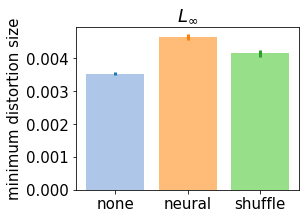

In [7]:
_, ax = plt.subplots(figsize=(4, 3))

h_bars = []
for k_idx in range(len(catalog_keys)):
    if catalog[key]:
        ecolor = tab20_colors[k_idx*2]
        fcolor = tab20_colors[k_idx*2+1]
        h_bars.append(ax.bar(k_idx, dists_mean[k_idx], 0.8, facecolor=fcolor))
        ax.errorbar(k_idx, dists_mean[k_idx], dists_sem[k_idx], linestyle='none', ecolor=ecolor)
ax.set_xticks(np.arange(len(catalog_keys)))
ax.set_xticklabels(catalog_keys)
ax.set_ylabel('minimum distortion size')
ax.set_title(r'$L_\infty$')
plt.show()